In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tensorflow.keras.models import Model
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dot
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
import matplotlib.pyplot as plt


In [ ]:
IMAGE_SIZE = (60, 80)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Final Fashion Dataset.csv')
df.head()

,user_id,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link,ratings,review,Month,Price (USD)
0,93810,8493,Women,Apparel,Bottomwear,Skirts,Black,Fall,2011.0,Casual,Forever New Women Black Skirts,8493.jpg,http://assets.myntassets.com/v1/images/style/p...,5,Amazing quality! Definitely recommend. Would r...,November,46
1,24592,30757,Men,Apparel,Topwear,Kurtas,Grey,Summer,2012.0,Ethnic,Fabindia Men Grey Mangalgiri Kurta,30757.jpg,http://assets.myntassets.com/v1/images/style/p...,4,"Perfect for any occasion, great buy..",September,29
2,13278,14881,Women,Accessories,Bags,Handbags,Black,Summer,2011.0,Casual,United Colors of Benetton Women Solid Black Ha...,14881.jpg,http://assets.myntassets.com/v1/images/style/p...,3,"It's okay, nothing special.!",October,39
3,46048,48449,Men,Apparel,Topwear,Tshirts,Blue,Summer,2012.0,Casual,French Connection Men Blue T-shirt,48449.jpg,http://assets.myntassets.com/v1/images/style/p...,5,"Comfortable and stylish, worth the price. and ...",August,39
4,42098,4697,Unisex,Accessories,Watches,Watches,Black,Winter,2016.0,Sports,ADIDAS Unisex Digital Duramo Black Watch,4697.jpg,http://assets.myntassets.com/v1/images/style/p...,4,"Perfect for any occasion, great buy.!",March,33


In [ ]:
# Encode categorical columns
label_encoders = {}
for column in ['masterCategory', 'subCategory', 'articleType', 'gender', 'baseColour', 'season', 'usage']:
    le = LabelEncoder()
    df[f'{column}_encoded'] = le.fit_transform(df[column])
    label_encoders[column] = le


In [ ]:
complementary_map = {
    'Topwear': ['Bottomwear', 'Shoes', 'Jewellery', 'Eyewear', 'Belts', 'Bags', 'Watches', 'Wallets'],
    'Bottomwear': ['Topwear', 'Shoes', 'Bags', 'Belts', 'Watches', 'Wallets'],
    'Bags': ['Topwear', 'Bottomwear', 'Shoes', 'Watches', 'Jewellery', 'Eyewear'],
    'Watches': ['Topwear', 'Bottomwear', 'Bags', 'Shoes', 'Jewellery'],
    'Shoes': ['Topwear', 'Bottomwear', 'Socks', 'Eyewear', 'Belts'],
    'Flip Flops': ['Topwear', 'Bottomwear', 'Socks', 'Belts', 'Eyewear'],
    'Jewellery': ['Topwear', 'Saree', 'Watches', 'Eyewear'],
    'Eyewear': ['Topwear', 'Bottomwear', 'Shoes', 'Jewellery'],
    'Belts': ['Topwear', 'Bottomwear', 'Shoes', 'Watches'],
    'Saree': ['Jewellery', 'Bags', 'Shoes'],
    'Loungewear and Nightwear': ['Bottomwear', 'Socks'],
    'Wallets': ['Topwear', 'Bottomwear', 'Bags', 'Watches'],
    'Socks': ['Shoes','Loungewear and Nightwear']
}


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
num_masterCategory = len(df['masterCategory'].unique())
num_subCategory = len(df['subCategory'].unique())
num_articleType = len(df['articleType'].unique())
num_gender = len(df['gender'].unique())
num_baseColour = len(df['baseColour'].unique())
num_season = len(df['season'].unique())
num_usage = len(df['usage'].unique())


In [ ]:
def create_complementary_model(num_categories, num_gender, num_colors, num_seasons, num_usage, embedding_dim=10):
    # Inputs
    input_masterCategory = Input(shape=(1,), name='masterCategory')
    input_subCategory = Input(shape=(1,), name='subCategory')
    input_articleType = Input(shape=(1,), name='articleType')
    input_gender = Input(shape=(1,), name='gender')
    input_baseColour = Input(shape=(1,), name='baseColour')
    input_season = Input(shape=(1,), name='season')
    input_usage = Input(shape=(1,), name='usage')
    input_price = Input(shape=(1,), name='Price (USD)')

    # Embedding layers for categorical features
    masterCategory_embedding = Embedding(input_dim=num_masterCategory + 1, output_dim=embedding_dim)(input_masterCategory)
    subCategory_embedding = Embedding(input_dim=num_subCategory + 1, output_dim=embedding_dim)(input_subCategory)
    articleType_embedding = Embedding(input_dim=num_articleType + 1, output_dim=embedding_dim)(input_articleType)
    gender_embedding = Embedding(input_dim=num_gender + 1, output_dim=4)(input_gender)
    baseColour_embedding = Embedding(input_dim=num_baseColour + 1, output_dim=45)(input_baseColour)
    season_embedding = Embedding(input_dim=num_season + 1, output_dim=4)(input_season)
    usage_embedding = Embedding(input_dim=num_usage + 1, output_dim=7)(input_usage)

    # Flatten embeddings
    masterCategory_flat = Flatten()(masterCategory_embedding)
    subCategory_flat = Flatten()(subCategory_embedding)
    articleType_flat = Flatten()(articleType_embedding)
    gender_flat = Flatten()(gender_embedding)
    baseColour_flat = Flatten()(baseColour_embedding)
    season_flat = Flatten()(season_embedding)
    usage_flat = Flatten()(usage_embedding)

    # Concatenate all features
    concat = Concatenate()([
        masterCategory_flat, subCategory_flat, articleType_flat,
        gender_flat, baseColour_flat, season_flat, usage_flat, input_price
    ])

    # Dense layers
    dense1 = Dense(128, activation='relu')(concat)
    dense2 = Dense(64, activation='relu')(dense1)

    # Output layer with one node per subCategory (complementary recommendation output)
    complementary_output = Dense(len(df['subCategory_encoded'].unique()), activation='sigmoid', name='complementary')(dense2)

    # Model
    model = Model(inputs=[
        input_masterCategory, input_subCategory, input_articleType,
        input_gender, input_baseColour, input_season, input_usage, input_price
    ], outputs=[complementary_output])

    return model


In [ ]:
# Initialize model
model = create_complementary_model(
    num_categories=len(df['subCategory_encoded'].unique()),
    num_gender=len(df['gender_encoded'].unique()),
    num_colors=len(df['baseColour_encoded'].unique()),
    num_seasons=len(df['season_encoded'].unique()),
    num_usage=len(df['usage_encoded'].unique())
)


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy')


In [ ]:
# Generate training pairs and labels based on complementary relationships
def generate_training_pairs(df, complementary_map, label_encoders):
    pairs = []
    labels = []

    for _, row in df.iterrows():
        main_subCategory = row['subCategory']
        main_subCategory_encoded = row['subCategory_encoded']

        if main_subCategory in complementary_map:
            for comp_subCategory in complementary_map[main_subCategory]:
                if comp_subCategory in label_encoders['subCategory'].classes_:
                    comp_subCategory_encoded = label_encoders['subCategory'].transform([comp_subCategory])[0]

                    # Add pair (main item, complementary item)
                    pairs.append([
                        row['masterCategory_encoded'], row['subCategory_encoded'], row['articleType_encoded'],
                        row['gender_encoded'], row['baseColour_encoded'], row['season_encoded'],
                        row['usage_encoded'], row['Price (USD)']
                    ])
                    # Set binary labels for complementary categories (one-hot encoded style)
                    label = np.zeros(len(df['subCategory_encoded'].unique()))
                    label[comp_subCategory_encoded] = 1
                    labels.append(label)

    return np.array(pairs), np.array(labels)

In [ ]:
# Generate training pairs and labels for train and test sets
X_train, y_train = generate_training_pairs(train_df, complementary_map, label_encoders)
X_test, y_test = generate_training_pairs(test_df, complementary_map, label_encoders)


In [ ]:
# Check shapes of X_train columns and y_train
for i in range(X_train.shape[1]):
    print(f"X_train[:, {i}] shape: {X_train[:, i].shape}, dtype: {X_train[:, i].dtype}")


X_train[:, 0] shape: (29640,), dtype: int64
X_train[:, 1] shape: (29640,), dtype: int64
X_train[:, 2] shape: (29640,), dtype: int64
X_train[:, 3] shape: (29640,), dtype: int64
X_train[:, 4] shape: (29640,), dtype: int64
X_train[:, 5] shape: (29640,), dtype: int64
X_train[:, 6] shape: (29640,), dtype: int64
X_train[:, 7] shape: (29640,), dtype: int64


In [ ]:
print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")


y_train shape: (29640, 13), dtype: float64


In [ ]:
# Convert X_train to int32
X_train = X_train.astype('int32')


In [ ]:
# Convert y_train to float32
y_train = y_train.astype('float32')


In [ ]:
# Train the model
model.fit([X_train[:, 0], X_train[:, 1], X_train[:, 2], X_train[:, 3], X_train[:, 4], X_train[:, 5], X_train[:, 6], X_train[:, 7]], y_train, epochs=10, batch_size=32)


Epoch 1/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3186
Epoch 2/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2228
Epoch 3/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2193
Epoch 4/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2179
Epoch 5/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2166
Epoch 6/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.2164
Epoch 7/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2160
Epoch 8/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2158
Epoch 9/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2157
Epoch 10/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2154


In [ ]:
# Function to recommend complementary items (no change)
def recommend_complementary_with_ids(item_id, df, model, label_encoders):
    item = df[df['id'] == item_id].iloc[0]
    subcategory = item['subCategory']

    input_data = [
        np.array([item['masterCategory_encoded']]),
        np.array([item['subCategory_encoded']]),
        np.array([item['articleType_encoded']]),
        np.array([item['gender_encoded']]),
        np.array([item['baseColour_encoded']]),
        np.array([item['season_encoded']]),
        np.array([item['usage_encoded']]),
        np.array([item['Price (USD)']])
    ]

    # Get model predictions for complementary subcategories
    predictions = model.predict(input_data)[0]
    top_complementary_indices = predictions.argsort()[::-1]
    complementary_subCategories = [label_encoders['subCategory'].inverse_transform([i])[0] for i in top_complementary_indices]

    recommendations = []

    # Find a sample product ID for each complementary subcategory
    for subCategory in complementary_subCategories:
        if subCategory in complementary_map[subcategory]:
            complementary_items = df[(df['subCategory'] == subCategory) & (df['gender'] == item['gender']) & (df['usage'] == item['usage'])]
            if not complementary_items.empty:
                sample_item = complementary_items.sample(1).iloc[0]
                recommendations.append((subCategory, sample_item['id']))
            else:
                recommendations.append((subCategory, None))

    return recommendations

In [ ]:
def get_product_details(product_id, df):
  """
  Retrieves the details of a product based on its ID.

  Args:
    product_id: The ID of the product to retrieve.
    df: The pandas DataFrame containing the product data.

  Returns:
    A pandas Series containing the product details, or None if the product ID
    is not found.
  """
  try:
    product_details = df[df['id'] == product_id].iloc[0]
    return product_details
  except IndexError:
    return None


In [ ]:
# Example usage:
product_id_to_check = 31781  # Replace with the desired product ID
product_details = get_product_details(product_id_to_check, df)


In [ ]:
if product_details is not None:
  print(f"Details for product ID {product_id_to_check}:")
  print(product_details)
else:
  print(f"Product with ID {product_id_to_check} not found in the dataset.")


Product with ID 31781 not found in the dataset.


In [ ]:
random_product_ids = [8493,30757,14881,48449,4697,52816,12868,17968,3940,46596]


In [ ]:
item_id = 27710 # Replace with an actual product ID from your dataset
recommendations = recommend_complementary_with_ids(item_id, df, model, label_encoders)
print(f"Recommended complementary items for product ID {item_id}: {recommendations}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Recommended complementary items for product ID 27710: [('Eyewear', 38225), ('Topwear', 13267), ('Shoes', 46583), ('Jewellery', 42625), ('Bottomwear', 22462), ('Watches', 45186)]


In [ ]:
from PIL import Image
path_images = []
image_url = "//content//drive//MyDrive//images//"
for i in recommendations:
    if i[1] is not None:
        path_images.append(image_url + df[df.id==i[1]]['filename'].values[0])
path_images


['//content//drive//MyDrive//images//38225.jpg',
 '//content//drive//MyDrive//images//13267.jpg',
 '//content//drive//MyDrive//images//46583.jpg',
 '//content//drive//MyDrive//images//42625.jpg',
 '//content//drive//MyDrive//images//22462.jpg',
 '//content//drive//MyDrive//images//45186.jpg']

In [ ]:
import cv2
import numpy as np
from PIL import Image


In [ ]:
image_path = f'//content//drive//MyDrive//images//{item_id}.jpg'


In [ ]:
pil_image = Image.open(image_path)
image_array = np.array(pil_image)
resized_image = cv2.resize(image_array, IMAGE_SIZE)

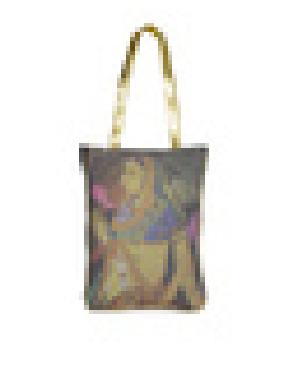

In [ ]:
plt.imshow(resized_image)
plt.axis("off")
plt.show()

In [ ]:
rec_images = []
for i in path_images:
    pil_image = Image.open(i)
    image_array = np.array(pil_image)
    resized_image = cv2.resize(image_array, IMAGE_SIZE)
    rec_images.append(resized_image)


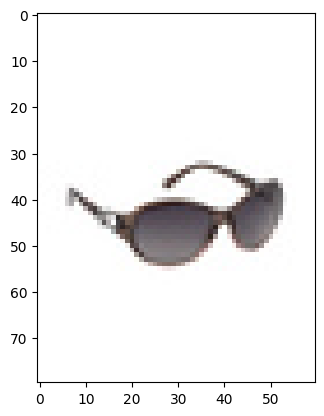

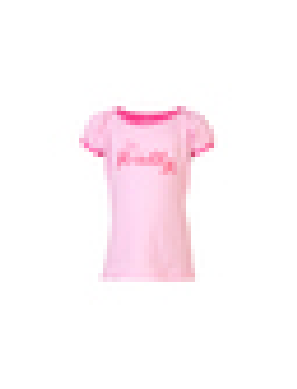

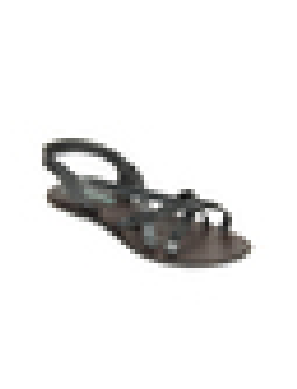

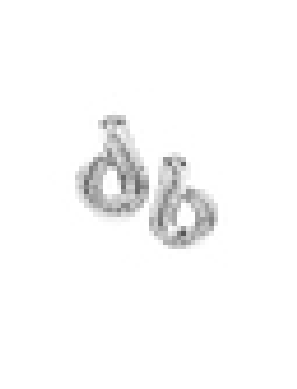

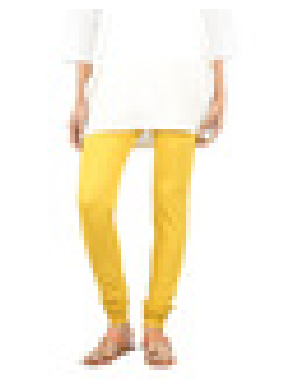

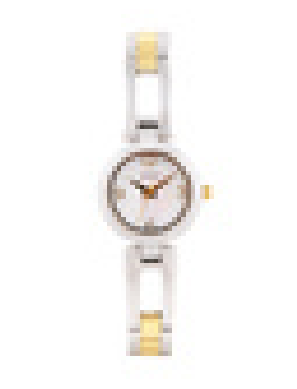

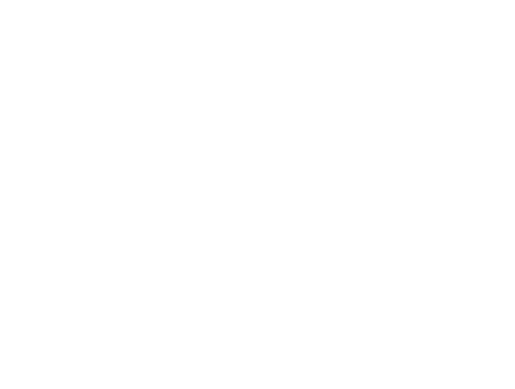

In [ ]:
for i in rec_images:
    plt.imshow(i)
    plt.show()
    plt.axis("off")

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

In [ ]:
def evaluate_model_at_k(model, test_df, complementary_map, label_encoders, k=5):
    precision_at_k = []
    recall_at_k = []
    f1_at_k = []

    # Generate predictions for each item in the test set
    for _, row in test_df.iterrows():
        true_subCategory = row['subCategory']
        true_complementary_categories = complementary_map.get(true_subCategory, [])
        true_complementary_indices = [
            label_encoders['subCategory'].transform([cat])[0]
            for cat in true_complementary_categories
            if cat in label_encoders['subCategory'].classes_
        ]

        # Prepare input data for prediction
        input_data = [
            np.array([row['masterCategory_encoded']]),
            np.array([row['subCategory_encoded']]),
            np.array([row['articleType_encoded']]),
            np.array([row['gender_encoded']]),
            np.array([row['baseColour_encoded']]),
            np.array([row['season_encoded']]),
            np.array([row['usage_encoded']]),
            np.array([row['Price (USD)']])
        ]

        # Predict complementary categories
        predictions = model.predict(input_data)[0]
        top_k_indices = predictions.argsort()[::-1][:k]

        # Generate binary arrays for true and predicted categories at K
        y_true = np.zeros(len(predictions))
        y_pred = np.zeros(len(predictions))

        y_true[true_complementary_indices] = 1
        y_pred[top_k_indices] = 1

        # Calculate precision, recall, and F1 for this item
        precision = precision_score(y_true, y_pred, zero_division=1)
        recall = recall_score(y_true, y_pred, zero_division=1)
        f1 = f1_score(y_true, y_pred, zero_division=1)

        precision_at_k.append(precision)
        recall_at_k.append(recall)
        f1_at_k.append(f1)

    # Average metrics over all items in test set
    avg_precision_at_k = np.mean(precision_at_k)
    avg_recall_at_k = np.mean(recall_at_k)
    avg_f1_at_k = np.mean(f1_at_k)

    return avg_precision_at_k, avg_recall_at_k, avg_f1_at_k

In [ ]:
# Evaluate model at K=5
precision_at_5, recall_at_5, f1_at_5 = evaluate_model_at_k(model, test_df, complementary_map, label_encoders, k=5)

print(f"Precision@5: {precision_at_5:.4f}")
print(f"Recall@5: {recall_at_5:.4f}")
print(f"F1@5: {f1_at_5:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━